In [23]:
import fitsio
from pathlib import Path
import argparse
import numpy as np
from acm.estimators.galaxy_clustering import DensitySplit
from acm import setup_logging
from cosmoprimo.fiducial import AbacusSummit


def get_hod_positions(input_fn, los='z'):
    hod = fitsio.read(input_fn)
    pos = np.c_[hod['X'], hod['Y'], hod['Z']]
    hubble = 100 * cosmo.efunc(redshift)
    scale_factor = 1 / (1 + redshift)
    if los == 'x':
        pos[:, 0] += hod['VX'] / (hubble * scale_factor)
    elif los == 'y':
        pos[:, 1] += hod['VY'] / (hubble * scale_factor)
    elif los == 'z':
        pos[:, 2] += hod['VZ'] / (hubble * scale_factor)
    return pos


hods = [78]


sedges = np.arange(0, 201, 1)
muedges = np.linspace(-1, 1, 241)
edges = (sedges, muedges)

cosmo = AbacusSummit(0)
redshift = 0.5

setup_logging()
ds = DensitySplit(boxsize=2000, boxcenter=2000/2, cellsize=4.0)

# load the HODs
for hod in hods:
    print('Processing HOD', hod)
    hod_dir = '/pscratch/sd/e/epaillas/emc/hods/z0.5/yuan23_prior/c000_ph000'
    hod_fn = Path(hod_dir) / f'hod{hod:03}.fits'
    print(hod_fn)

    for i, los in enumerate(['x', 'y', 'z']):
        hod_positions = get_hod_positions(hod_fn, los=los)

        ds.assign_data(positions=hod_positions, wrap=True, clear_previous=True)
        ds.set_density_contrast(smoothing_radius=10, save_wisdom=False)
        ds.set_quantiles(nquantiles=5, query_method='randoms')

        # ccf_los = ds.quantile_data_correlation(hod_positions, edges=edges, los=los, nthreads=4, gpu=True)

        acf_los = ds.quantile_correlation(edges=edges, los=los, nthreads=4, gpu=True)
        
        if i == 0:
            ccf = [ccf.normalize() for ccf in ccf_los]
            acf = [acf.normalize() for acf in acf_los]
        else:
            for q in range(5):
                ccf[q] += ccf_los[q].normalize()
                acf[q] += acf_los[q].normalize()



[000000.00]  05-17 11:34  DensitySplit                 INFO     Initializing DensitySplit.
[000000.00]  05-17 11:34  DensitySplit                 INFO     Box size: [2000. 2000. 2000.]
[000000.00]  05-17 11:34  DensitySplit                 INFO     Box center: [1000. 1000. 1000.]
[000000.00]  05-17 11:34  DensitySplit                 INFO     Box nmesh: [500 500 500]
Processing HOD 78
/pscratch/sd/e/epaillas/emc/hods/z0.5/yuan23_prior/c000_ph000/hod078.fits
[000001.84]  05-17 11:34  DensitySplit                 INFO     Set density contrast in 1.25 seconds.
[000001.84]  05-17 11:34  DensitySplit                 INFO     Generating random query points within the box.
[000004.21]  05-17 11:34  DensitySplit                 INFO     Quantiles calculated in 2.37 seconds.
[000004.21]  05-17 11:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000004.21]  05-17 11:34  TwoPointCorrelationFunction  INFO     Running auto-corr

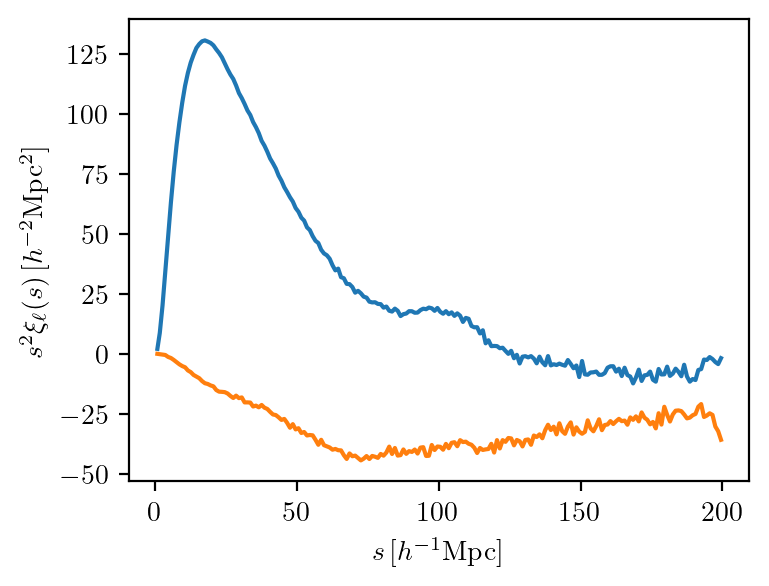

In [36]:
fig, ax = plt.subplots(figsize=(4, 3))

quantiles = [3]

for q in quantiles:
    result = acf[q]
    s, multipoles = result(ells=(0, 2, 4), return_sep=True)
    ax.plot(s, s**2*multipoles[0])
    ax.plot(s, s**2*multipoles[1])

ymin, ymax = ax.get_ylim()
ax.set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax.set_ylabel(r'$s^2\xi_\ell(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.show()

160


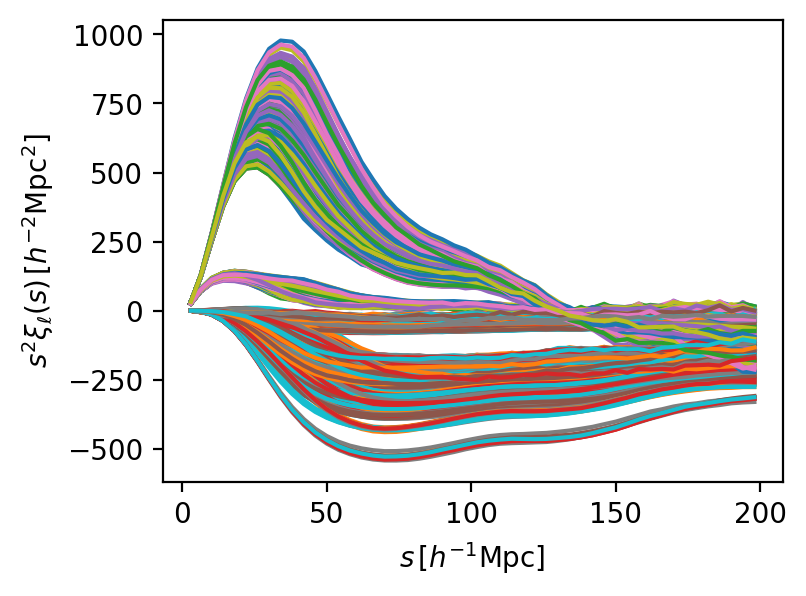

In [21]:
import fitsio
from pathlib import Path
import argparse
import numpy as np
from acm.estimators.galaxy_clustering import DensitySplit
from acm import setup_logging
from cosmoprimo.fiducial import AbacusSummit
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


hods = np.array([
    53,   62,   78,   88,  169,  177,  405,  460,  506,  538,  557,
    600,  605,  652,  659,  689,  715,  862,  879,  883,  921,  933,
    961, 1065, 1113, 1160, 1264, 1432, 1523, 1633, 1680, 1802, 1862,
    1997, 2009, 2074, 2210, 2278, 2333, 2418, 2464, 2494, 2506, 2509,
    2515, 2697, 2909, 2964, 2971, 3065, 3117, 3166, 3360, 3478, 3534,
    3602, 3699, 3714, 3718, 3765, 3772, 3997, 4053, 4103, 4146, 4545,
    4650, 4669, 4688, 4743, 4753, 4793, 4830, 4868, 4942, 4989, 5071,
    5109, 5113, 5192, 5197, 5250, 5292, 5295, 5360, 5439, 5473, 5584,
    5669, 5811, 5829, 5884, 5890, 5999, 6003, 6048, 6083, 6146, 6162,
    6350, 6364, 6388, 6449, 6462, 6597, 6605, 6609, 6655, 6678, 6850,
    6904, 6914, 6916, 6985, 7035, 7152, 7429, 7522, 7543, 7550, 7578,
    7674, 7797, 7838, 7973, 7986, 8012, 8113, 8169, 8208, 8236, 8272,
    8303, 8336, 8398, 8444, 8464, 8704, 8732, 8796, 8899, 8946, 9055,
    9120, 9131, 9270, 9287, 9300, 9305, 9386, 9456, 9489, 9562, 9580,
    9677, 9725, 9730, 9814, 9843, 9975,
])

print(len(hods))

quantiles = [0, 1, 3, 4]
ells = (0, 2)
statistic = 'quantile_correlation'
# hods = [62, 78,  88, 169, 177]
# hods = [78]

fig, ax = plt.subplots(figsize=(4, 3))

multipoles_hod = []

for hod in hods:
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/density_split/{statistic}/z0.5/yuan23_prior/c000_ph000/seed0/bugfix'
    data_fn = Path(data_dir) / f'{statistic}_hod{hod:03}.npy'
    data = np.load(data_fn, allow_pickle=True)

    multipoles_quantiles = []
    for q in quantiles:
        result = data[q][::4]
        s, multipoles = result(ells=ells, return_sep=True)
        ax.plot(s, s**2*multipoles[0])
        ax.plot(s, s**2*multipoles[1])
        
# ax.set_ylim(ymin, ymax)
    
ax.set_xlabel(r'$s\,[h^{-1}{\rm Mpc}]$')
ax.set_ylabel(r'$s^2\xi_\ell(s)\,[h^{-2}{\rm Mpc^2}]$')
plt.show()